# Raw image viewer (minimal)

Load and visualize raw binary image dumps such as:
- `original_rgb.raw` (RGB24, 2048×2048)
- `pal_ycbcr422.raw` (YCbCr 4:2:2 packed, 720×576)

You can tweak width/height, pixel format, interlace assumptions, and color mapping.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path('.')  # change if needed

def read_bytes(path: str | Path) -> np.ndarray:
    path = Path(path)
    return np.frombuffer(path.read_bytes(), dtype=np.uint8)

def show(img, title=None):
    plt.figure()
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


## RGB24 (packed) viewer

**Format:** row-major `R,G,B` bytes per pixel.

Set `w`, `h` and `path` as needed.


bytes: 12582912 expected: 12582912


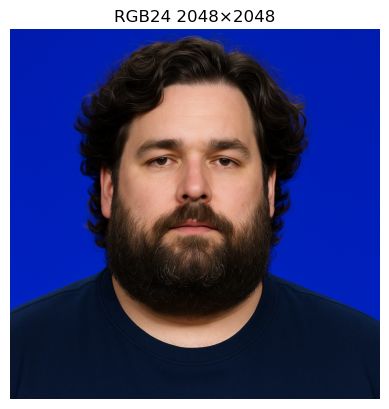

In [2]:
# --- RGB24 viewer ---
path = DATA_DIR / 'original_rgb.raw'
w, h = 2048, 2048

buf = read_bytes(path)
expected = w * h * 3
print('bytes:', buf.size, 'expected:', expected)

# Truncate or pad to expected length (handy while experimenting)
if buf.size < expected:
    buf = np.pad(buf, (0, expected - buf.size))
elif buf.size > expected:
    buf = buf[:expected]

img = buf.reshape((h, w, 3))
show(img, f'RGB24 {w}×{h}')


## Interlace playground (field split / weave)

Given a progressive image `img` (H×W×C), this lets you:
- **split into fields** (even/odd lines)
- **weave** fields back together
- optionally **swap field order**


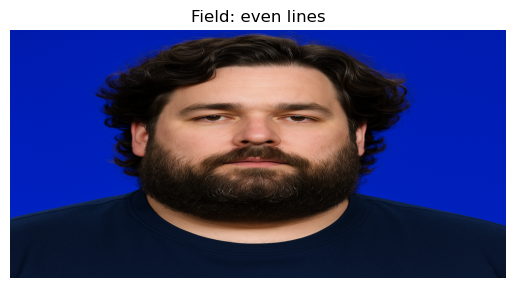

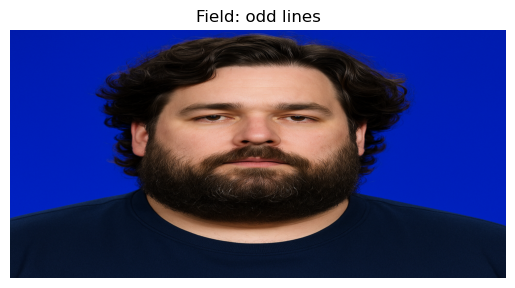

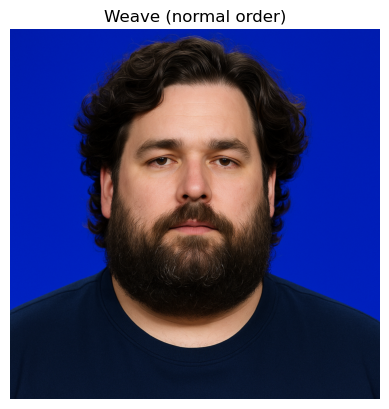

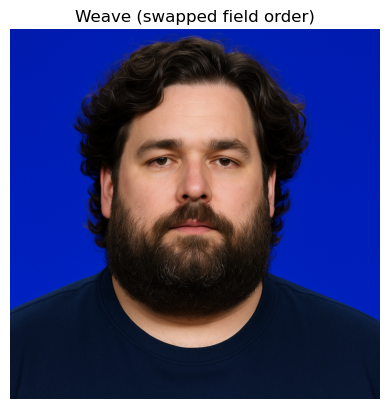

In [3]:
def split_fields(img):
    even = img[0::2].copy()
    odd  = img[1::2].copy()
    return even, odd

def weave_fields(even, odd, swap=False):
    if swap:
        even, odd = odd, even
    h2, w = even.shape[0], even.shape[1]
    out = np.zeros((h2*2, w) + even.shape[2:], dtype=even.dtype)
    out[0::2] = even
    out[1::2] = odd
    return out

# Try it on the last-loaded RGB image:
even, odd = split_fields(img)
show(even, 'Field: even lines')
show(odd,  'Field: odd lines')
show(weave_fields(even, odd, swap=False), 'Weave (normal order)')
show(weave_fields(even, odd, swap=True),  'Weave (swapped field order)')


## YCbCr 4:2:2 (packed) viewer

This is meant for files like `pal_ycbcr422.raw`.

### Supported packings
- **YUYV** (a.k.a. YUY2): `Y0 U Y1 V`
- **UYVY**: `U Y0 V Y1`

You can experiment by switching `packing`.


bytes: 1244160 expected: 829440


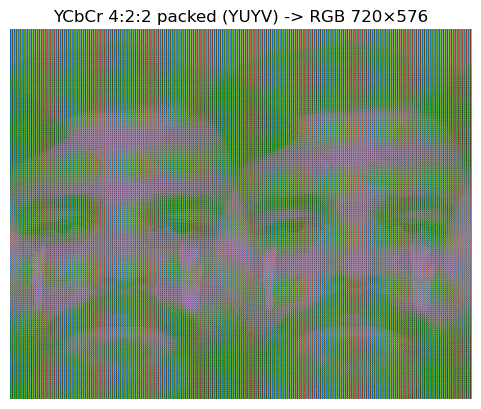

In [4]:
def ycbcr_to_rgb_bt601(y, cb, cr):
    """BT.601 full-range-ish conversion (uint8 -> float -> uint8).
    This is good enough for visual inspection.
    """
    y  = y.astype(np.float32)
    cb = cb.astype(np.float32) - 128.0
    cr = cr.astype(np.float32) - 128.0

    r = y + 1.4020 * cr
    g = y - 0.344136 * cb - 0.714136 * cr
    b = y + 1.7720 * cb

    rgb = np.stack([r, g, b], axis=-1)
    return np.clip(rgb, 0, 255).astype(np.uint8)

def parse_422_packed(buf, w, h, packing='YUYV'):
    """Parse packed 4:2:2 buffer into Y, Cb, Cr planes at 4:4:4 resolution."""
    # 2 bytes per pixel
    expected = w * h * 2
    if buf.size < expected:
        buf = np.pad(buf, (0, expected - buf.size))
    elif buf.size > expected:
        buf = buf[:expected]

    data = buf.reshape((h, w//2, 4))  # 2 pixels per group
    if packing.upper() == 'YUYV':
        y0 = data[..., 0]
        u  = data[..., 1]
        y1 = data[..., 2]
        v  = data[..., 3]
    elif packing.upper() == 'UYVY':
        u  = data[..., 0]
        y0 = data[..., 1]
        v  = data[..., 2]
        y1 = data[..., 3]
    else:
        raise ValueError("packing must be 'YUYV' or 'UYVY'")

    # Expand to per-pixel 4:4:4
    y = np.empty((h, w), dtype=np.uint8)
    cb = np.empty((h, w), dtype=np.uint8)
    cr = np.empty((h, w), dtype=np.uint8)

    y[:, 0::2] = y0
    y[:, 1::2] = y1
    cb[:, 0::2] = u
    cb[:, 1::2] = u
    cr[:, 0::2] = v
    cr[:, 1::2] = v

    return y, cb, cr

# --- PAL 4:2:2 viewer ---
path = DATA_DIR / 'pal_ycbcr422.raw'
w, h = 720, 576
packing = 'YUYV'  # try 'UYVY'

buf = read_bytes(path)
print('bytes:', buf.size, 'expected:', w*h*2)

y, cb, cr = parse_422_packed(buf, w, h, packing=packing)
rgb = ycbcr_to_rgb_bt601(y, cb, cr)

show(rgb, f'YCbCr 4:2:2 packed ({packing}) -> RGB {w}×{h}')


## Quick diagnostics

If the image looks wrong:
- Try swapping `packing` between `YUYV` and `UYVY`.
- Try `w, h` guesses (especially if you’re exploring unknown raws).
- Use the interlace cell above: field order issues often look like combing or line jitter.
